Cette Partie est dédiée à la Transformation de notre Texte et donc à la création de features exploitable pour le Machine Learning.
Nous allons Testser différentes méthodes de représentation de nos document :
(1) Méthodes de comptage direct :
    - Approche Bag of Words
    - Approche n-gram (Bag of words généralisé)
    - Approche TF-IDF

(2) Méthode plongement de mot

https://www.kaggle.com/code/miljan/predicting-tags-for-stackoverflow/notebook

# <font color = Green>Partie 1 : n-gram et TF-IDF</font>

## <font color = purple>1. Préléminaires</font>

### <font color = grey>1.1 Contexte</font>

TEXTE INTRO

### <font color = grey>1.2 Librairies</font>

In [82]:
import nltk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer

### <font color = grey>1.3 Chargement des données</font>

In [26]:
#Chemin de notre fichier source
data = "cleaned/"
os.listdir(data)

#Chargement du Dataframe
fn = data + 'final_df.csv'
df = pd.read_csv(fn)
df.head()

,Title,Body,Tags,clean_title
0,"Differences between declare, typeset and local...","<p>When typing variables in Bash, what is the ...",<bash><shell><variables><scope><declare>,differ declar local variabl bash
1,Dealing with PHP server and MySQL server in di...,<p>For those of us who use standard shared hos...,<php><mysql><datetime><date><timezone>,deal php server mysql server differ time
2,Difference between async/await and ES6 yield w...,<p>I was just reading this fantastic article «...,<javascript><node.js><ecmascript-6><generator>...,differ async await yield gener
3,Loading System.ServiceModel configuration sect...,"<p>Using C# .NET 3.5 and WCF, I'm trying to wr...",<c#><.net><xml><wcf><configurationmanager>,load system configur section use
4,XML Serialization and Inherited Types,"<p>Following on from my <a href=""https://stack...",<c#><xml><inheritance><serialization><xml-seri...,xml serial inherit type


-----

## <font color = purple>2. approche Bag of Words</font>

A AJOUTER DANS LE PREMIER NOTEBOOK

In [27]:
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]
rows_with_NaN

,Title,Body,Tags,clean_title
53,What is a Y-combinator?,<p>A Y-combinator is a computer science concep...,<functional-programming><computer-science><the...,NaN
324,"What does if __name__ == ""__main__"": do?","<p>What does this do, and why should one inclu...",<python><namespaces><main><python-module><idioms>,NaN
741,"A* heuristic, overestimation/underestimation?",<p>I am confused about the terms overestimatio...,<algorithm><search><graph><artificial-intellig...,NaN
1564,What are vdso and vsyscall?,<p>I did <code>sudo cat /proc/1/maps -vv</code...,<c><linux><linux-kernel><kernel><vdso>,NaN
1847,Grokking Timsort,<p>There's a (relatively) new sort on the bloc...,<java><python><algorithm><sorting><timsort>,NaN
2162,Atomicity on x86,<blockquote>\n <h2>8.1.2 Bus Locking</h2>\n ...,<c++><multithreading><x86><atomic><memory-barr...,NaN
2726,Checkstyle vs. PMD,<p>We are introducing static analysis tools in...,<java><static-analysis><findbugs><checkstyle><...,NaN
4037,What is a clearfix?,<p>Recently I was looking through some website...,<html><css><layout><cross-browser><clearfix>,NaN
4303,Why there is no ConcurrentHashSet against Conc...,<p>HashSet is based on HashMap.</p>\n\n<p>If w...,<java><collections><concurrency><hashmap><hash...,NaN
7847,What is 1LL or 2LL in C and C++?,<p>I was looking at some of the solutions in G...,<c++><c><math><long-integer><cmath>,NaN


In [28]:
df = df.dropna()

In [29]:
#Initialize
CountVec = CountVectorizer(ngram_range=(1,1)) # to use bigrams ngram_range=(2,2)

#transform
Count_data = CountVec.fit_transform(df["clean_title"])

#create dataframe
X_bag_of_words=pd.DataFrame(Count_data.toarray(),columns=CountVec.get_feature_names_out())

In [30]:
#affichage
X_bag_of_words.head(10)

,aac,aadhaar,aapt,aar,ab,abaddressbook,abbrevi,abi,abl,abort,...,zone,zookeep,zoom,zoomabl,zoomtablemanag,zpl,zsh,zuul,zxing,zzabn
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## <font color = purple>3. approche n-gram </font>

stop_words: Since CountVectorizer just counts the occurrences of each word in its vocabulary, extremely common words like ‘the’, ‘and’, etc. will become very important features while they add little meaning to the text. Your model can often be improved if you don’t take those words into account. Stop words are just a list of words you don’t want to use as features. You can set the parameter stop_words=’english’ to use a built-in list. Alternatively you can set stop_words equal to some custom list. This parameter defaults to None.
ngram_range: An n-gram is just a string of n words in a row. E.g. the sentence ‘I am Groot’ contains the 2-grams ‘I am’ and ‘am Groot’. The sentence is itself a 3-gram. Set the parameter ngram_range=(a,b) where a is the minimum and b is the maximum size of ngrams you want to include in your features. The default ngram_range is (1,1).
In a recent project where I modeled job postings online, I found that including 2-grams as features boosted my model’s predictive power significantly. This makes intuitive sense; many job titles such as ‘data scientist’, ‘data engineer’, and ‘data analyst’ are 2 words long.
min_df, max_df: These are the minimum and maximum document frequencies words/n-grams must have to be used as features. If either of these parameters are set to integers, they will be used as bounds on the number of documents each feature must be in to be considered as a feature. If either is set to a float, that number will be interpreted as a frequency rather than a numerical limit. min_df defaults to 1 (int) and max_df defaults to 1.0 (float).
max_features: This parameter is pretty self-explanatory. The CountVectorizer will choose the words/features that occur most frequently to be in its’ vocabulary and drop everything else.
You would set these parameters when initializing your CountVectorizer object as shown below.

In [31]:
#Initialize
CountVec = CountVectorizer(ngram_range=(2,2)) # to use bigrams ngram_range=(2,2)

#transform
Count_data = CountVec.fit_transform(df["clean_title"])

#create dataframe
X_bigram=pd.DataFrame(Count_data.toarray(),columns=CountVec.get_feature_names_out())

In [32]:
X_bigram.sample(10)

,aac encod,aac stream,aadhaar card,aadhaar number,aapt adb,aapt ioexcept,aar depend,aar file,aar includ,aar jar,...,zsh configur,zsh mac,zsh recogn,zsh termin,zsh theme,zsh without,zuul authent,zuul nginx,zxing librari,zxing reader
18981,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
216,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4824,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23219,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17157,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21453,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15489,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5275,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7600,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


PRB == Matrice creuse !, peut être regler (sur le net)

## <font color = purple>4. approche TF - IDF </font>

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
#Initialize
tfidf = TfidfVectorizer(ngram_range=(1,1))
 
#transform
result = tfidf.fit_transform(df["clean_title"])

#create dataframe
X_tfidf=pd.DataFrame(result.toarray(),columns=tfidf.get_feature_names_out())

In [34]:
X_tfidf.sample(10)

,aac,aadhaar,aapt,aar,ab,abaddressbook,abbrevi,abi,abl,abort,...,zone,zookeep,zoom,zoomabl,zoomtablemanag,zpl,zsh,zuul,zxing,zzabn
14002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# <font color = Green>Partie 2 : Plongement de Mot</font>

https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial/notebook

https://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/

In [35]:
# imports needed and set up logging
import gzip
import gensim 
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [36]:
tokens = df["clean_title"].values.tolist()

In [37]:
type(tokens)

list

In [38]:
tokens

['differ declar local variabl bash',
 'deal php server mysql server differ time',
 'differ async await yield gener',
 'load system configur section use',
 'xml serial inherit type',
 'myisam versu innodb',
 'specifi mysql enum django model',
 'recommend sql databas design tag tag',
 'differ includ filenam includ filenam',
 'net get protocol host port',
 'commun servic layer messag error higher layer use mvp',
 'list',
 'programmat encrypt config file net',
 'jqueri ajax updatepanel',
 'jvm requir warmup',
 'size uitextview content',
 'batch file delet file older day',
 'real overhead tri catch',
 'cross platform space remain volum use python',
 'work done cross platform mobil develop',
 'file nodej',
 'javascript oop nodej',
 'cakephp acl databas setup structur',
 'select distinct multipl column',
 'use class struct',
 'good librari deal protocol net',
 'differ old style new style class python',
 'best way pars html',
 'kill session connect oracl databas',
 'convert pdf file imag',
 'o

In [39]:
# using list comprehension + split()
# Tokenizing strings in list of strings
res = [sub.split() for sub in tokens]

In [40]:
res

[['differ', 'declar', 'local', 'variabl', 'bash'],
 ['deal', 'php', 'server', 'mysql', 'server', 'differ', 'time'],
 ['differ', 'async', 'await', 'yield', 'gener'],
 ['load', 'system', 'configur', 'section', 'use'],
 ['xml', 'serial', 'inherit', 'type'],
 ['myisam', 'versu', 'innodb'],
 ['specifi', 'mysql', 'enum', 'django', 'model'],
 ['recommend', 'sql', 'databas', 'design', 'tag', 'tag'],
 ['differ', 'includ', 'filenam', 'includ', 'filenam'],
 ['net', 'get', 'protocol', 'host', 'port'],
 ['commun',
  'servic',
  'layer',
  'messag',
  'error',
  'higher',
  'layer',
  'use',
  'mvp'],
 ['list'],
 ['programmat', 'encrypt', 'config', 'file', 'net'],
 ['jqueri', 'ajax', 'updatepanel'],
 ['jvm', 'requir', 'warmup'],
 ['size', 'uitextview', 'content'],
 ['batch', 'file', 'delet', 'file', 'older', 'day'],
 ['real', 'overhead', 'tri', 'catch'],
 ['cross', 'platform', 'space', 'remain', 'volum', 'use', 'python'],
 ['work', 'done', 'cross', 'platform', 'mobil', 'develop'],
 ['file', 'nodej']

In [41]:
type(res)

list

In [71]:
model = gensim.models.Word2Vec(res, vector_size = 100, window=10, min_count=2, workers=10)
model.train(res,total_examples=len(res),epochs=10)

2022-09-08 11:03:33,943 : INFO : collecting all words and their counts
2022-09-08 11:03:33,943 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-09-08 11:03:33,960 : INFO : PROGRESS: at sentence #10000, processed 53677 words, keeping 4268 word types
2022-09-08 11:03:33,973 : INFO : PROGRESS: at sentence #20000, processed 108033 words, keeping 5160 word types
2022-09-08 11:03:33,983 : INFO : collected 5486 word types from a corpus of 150167 raw words and 27617 sentences
2022-09-08 11:03:33,983 : INFO : Creating a fresh vocabulary
2022-09-08 11:03:34,005 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=2 retains 4724 unique words (86.11009843237332%% of original 5486, drops 762)', 'datetime': '2022-09-08T11:03:34.005353', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'prepare_vocab'}
2022-09-08 11:03:34,005 : INFO : Word2Vec lifecycle event {'ms

(1388038, 1501670)

In [72]:
#Observer le vecteur de "use"
model.wv["use"]

array([ 0.01314341,  0.16199589, -0.09192473,  0.29032618, -0.5441391 ,
       -0.3739921 , -0.34580982, -0.18624996, -0.315735  , -0.4978553 ,
        0.21980262, -0.27210867,  0.20957817,  0.22424878, -0.63223344,
       -0.15405141, -0.15237935, -0.23781027,  0.05165326, -0.44562915,
        0.7580647 ,  0.2257903 ,  0.16482538, -0.22996874, -0.02176411,
        0.01502268, -0.03225233, -0.10605185, -0.44624865, -0.3011312 ,
       -0.24431387,  0.10686945,  0.23533973, -0.7897278 , -0.22808729,
        0.2352521 , -0.03943783, -0.3667043 , -0.46876246,  0.23197009,
        0.00311443,  0.19174314, -0.67160153,  0.58963954,  0.31067473,
       -0.31925017,  0.5875253 , -0.25247148,  0.15651749,  0.58736694,
       -0.10885954, -0.45379844, -0.14275238,  0.09534176,  0.27533787,
       -0.07240443, -0.03030825, -0.7286164 , -0.10581768, -0.10572167,
        0.21875072,  0.8786891 , -0.7944284 , -0.4421722 ,  0.16682363,
        0.18604788, -0.15996312,  0.46587378,  0.25918505,  0.59

In [43]:
#Les mots les plus similaire à use
w1 = "use"
model.wv.most_similar(positive=w1)

[('bouncycastl', 0.5382568836212158),
 ('work', 0.5318703651428223),
 ('deal', 0.5301653146743774),
 ('differ', 0.5171278119087219),
 ('fan', 0.5168708562850952),
 ('slug', 0.5163222551345825),
 ('registr', 0.5106717944145203),
 ('upstart', 0.5088768601417542),
 ('rewrit', 0.5072711110115051),
 ('moxi', 0.5048527121543884)]

In [44]:
#Les 6 mots les plus similaire à python
w1 = ["python"]
model.wv.most_similar (positive=w1,topn=6)

[('scipi', 0.6846134066581726),
 ('nltk', 0.6770803928375244),
 ('numpi', 0.6716992855072021),
 ('sever', 0.6320028901100159),
 ('perl', 0.6262149214744568),
 ('setuptool', 0.6173449754714966)]

In [45]:
#Similarité entre 2 mots :
model.wv.similarity(w1="java", w2="json")

0.29396608

In [46]:
#Similarité entre 2 mots identique :
model.wv.similarity(w1="java", w2="java")

1.0

In [78]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['use', 'java', 'python']}
similar_words

{'use': ['work', 'deal', 'digest', 'differ', 'transfer'],
 'java': ['util', 'lang', 'bcel', 'scala', 'noclassdeffounderror'],
 'python': ['distutil', 'perl', 'setuptool', 'nltk', 'numpi']}

In [79]:
from sklearn.manifold import TSNE

c:\Users\Anthony\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Anthony\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


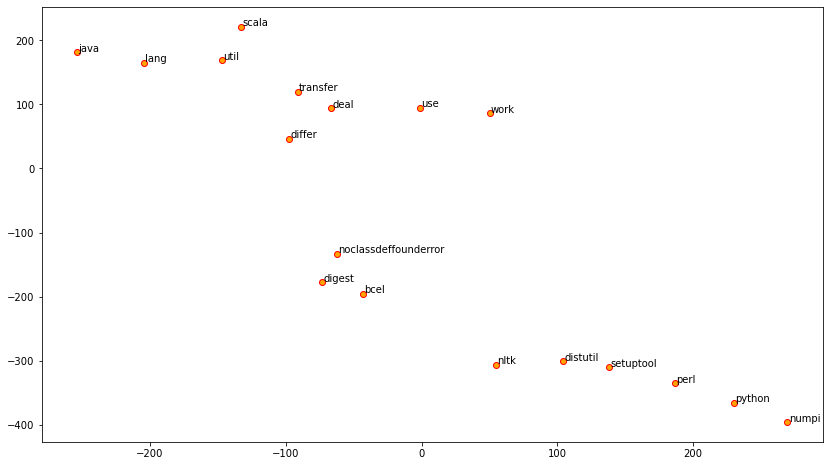

In [83]:
words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

https://edumunozsala.github.io/BlogEms/jupyter/nlp/classification/embeddings/python/2020/08/15/Intro_NLP_WordEmbeddings_Classification.html#Word-embeddings

<b>Applying the word embedding to a text classification task</b>
Now, we have our word representation, a vector for every word in our vocabulary. But we need to deal with full sentences so we need to create a sentence embedding, basically we need a vector that represent the whole sentence and every feature in the vector will be based on the word embeddings. There are many posibilities and we are notr going to cover this topic, so we apply a very simple method: the ith value in the sentence embedding will be the mean of the ith values in the word embedding of all the words in the sentence.

We will create a class that will contain our vocabulary and glove vectors and then it will transform every review (a sentence in our example) to a vector representation as we describe previously.

https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4

https://github.com/RaRe-Technologies/gensim/blob/3c3506d51a2caf6b890de3b1b32a8b85f7566ca5/docs/notebooks/doc2vec-IMDB.ipynb

Sympa : https://linanqiu.github.io/2015/10/07/word2vec-sentiment/

## Représentation 2D avec les mots ==> A FAIRE

# <font color = Green>Partie 3 : Latent Dirichley alloation (LDA)</font>

https://towardsdatascience.com/tags-recommendation-algorithm-using-latent-dirichlet-allocation-lda-3f844abf99d7

In [47]:
no_topics = 20

In [50]:
from sklearn.decomposition import LatentDirichletAllocation

In [52]:
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50,random_state=11).fit(X_tfidf)

Fonction d'affichage des topics :

In [53]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("--------------------------------------------")
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("--------------------------------------------")

In [57]:
display_topics(lda, tfidf.get_feature_names(), 5)

--------------------------------------------
Topic 0:
properti find row line algorithm
--------------------------------------------
--------------------------------------------
Topic 1:
except singl network sign certif
--------------------------------------------
--------------------------------------------
Topic 2:
array work number numpi bit
--------------------------------------------
--------------------------------------------
Topic 3:
json html object updat loop
--------------------------------------------
--------------------------------------------
Topic 4:
list read store two queri
--------------------------------------------
--------------------------------------------
Topic 5:
instal connect error memori node
--------------------------------------------
--------------------------------------------
Topic 6:
net asp mvc git core
--------------------------------------------
--------------------------------------------
Topic 7:
selenium delet output rubi folder
-----------------